<a href="https://colab.research.google.com/github/wrn6494/-8-Week-SQL-Challenge/blob/main/Case_Study_4_Data_Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8 Week SQL Challenge : Case Study #4 - Data Bank**

Full case study available [here.](https://8weeksqlchallenge.com/case-study-4/)

**Probem Statement/Business Task**

The management team at Data Bank want to increase their total customer base - but also need some help tracking just how much data storage their customers will need.

This case study is all about calculating metrics, growth and helping the business analyse their data in a smart way to better forecast and plan for their future developments!

**Entity Relationship Diagram**

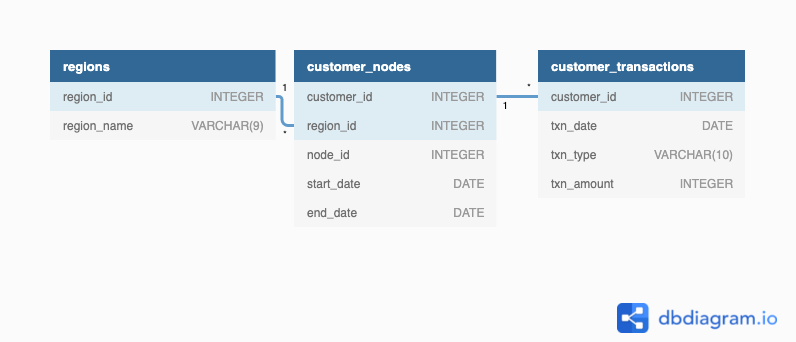

# Case Study Questions

**A. Customer Nodes Exploration**

1. How many unique nodes are there on the Data Bank system?
2. What is the number of nodes per region?
3. How many customers are allocated to each region?
4. How many days on average are customers reallocated to a different node?
5. What is the median, 80th and 95th percentile for this same reallocation days metric for each region?

**B. Customer Transactions**

1. What is the unique count and total amount for each transaction type?
2. What is the average total historical deposit counts and amounts for all customers?
3. For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?
4. What is the closing balance for each customer at the end of the month?
5. What is the percentage of customers who increase their closing balance by more than 5%?

**C. Data Allocation Challenge**

1. To test out a few different hypotheses - the Data Bank team wants to run an experiment where different groups of customers would be allocated data using 3 different options:

*   Option 1: data is allocated based off the amount of money at the end of the previous month 
*   Option 2: data is allocated on the average amount of money kept in the account in the previous 30 days
*   Option 3: data is updated real-time

For this multi-part challenge question - you have been requested to generate the following data elements to help the Data Bank team estimate how much data will need to be provisioned for each option:

*   running customer balance column that includes the impact each transaction
*   customer balance at the end of each month
*   minimum, average and maximum values of the running balance for each customer

Using all of the data available - how much data would have been required for each option on a monthly basis?

**D. Extra Challenge**

Data Bank wants to try another option which is a bit more difficult to implement - they want to calculate data growth using an interest calculation, just like in a traditional savings account you might have with a bank.

If the annual interest rate is set at 6% and the Data Bank team wants to reward its customers by increasing their data allocation based off the interest calculated on a daily basis at the end of each day, how much data would be required for this option on a monthly basis?

Special notes:

Data Bank wants an initial calculation which does not allow for compounding interest, however they may also be interested in a daily compounding interest calculation so you can try to perform this calculation if you have the stamina!
Extension Request
The Data Bank team wants you to use the outputs generated from the above sections to create a quick Powerpoint presentation which will be used as marketing materials for both external investors who might want to buy Data Bank shares and new prospective customers who might want to bank with Data Bank.

Using the outputs generated from the customer node questions, generate a few headline insights which Data Bank might use to market it’s world-leading security features to potential investors and customers.

With the transaction analysis - prepare a 1 page presentation slide which contains all the relevant information about the various options for the data provisioning so the Data Bank management team can make an informed decision.

#A. Customer Nodes Exploration

**A.1 How many unique nodes are there on the Data Bank system?**

    SELECT COUNT(DISTINCT node_id) FROM data_bank.customer_nodes;

| count |
| ----- |
| 5     |


**A.2 What is the number of nodes per region?**

    SELECT region_name,COUNT(node_id) 
    FROM data_bank.customer_nodes
    JOIN data_bank.regions
    USING (region_id)
    GROUP BY region_name;

| region_name | count |
| ----------- | ----- |
| America     | 735   |
| Australia   | 770   |
| Africa      | 714   |
| Asia        | 665   |
| Europe      | 616   |

**A.3 How many customers are allocated to each region?**


    SELECT region_name,COUNT(DISTINCT customer_id) 
    FROM data_bank.customer_nodes
    JOIN data_bank.regions
    USING (region_id)
    GROUP BY region_name;

| region_name | count |
| ----------- | ----- |
| Africa      | 102   |
| America     | 105   |
| Asia        | 95    |
| Australia   | 110   |
| Europe      | 88    |

**A.4 How many days on average are customers reallocated to a different node?**

    SELECT TRUNC(AVG(end_date-start_date),2) AS average_days
    FROM data_bank.customer_nodes
    WHERE end_date<>'9999-12-31';

| average_days |
| ------------ |
| 14.63        |


**A.5 What is the median, 80th and 95th percentile for this same reallocation days metric for each region?**

    WITH A AS
    (
    SELECT DISTINCT region_id, end_date-start_date AS days,
    	ROUND(PERCENT_RANK() OVER(PARTITION BY region_id ORDER BY (end_date-start_date))::NUMERIC,2) Rank
    FROM data_bank.customer_nodes
    WHERE end_date<>'9999-12-31'
    ORDER BY days DESC
    )

    SELECT region_name,days
    FROM A
    JOIN data_bank.regions
    USING (region_id)
    WHERE rank IN (0.50,0.51,0.52,0.53);

| region_name | days |
| ----------- | ---- |
| Australia   | 16   |
| America     | 16   |
| Africa      | 16   |
| Asia        | 15   |
| Asia        | 16   |
| Europe      | 16   |  

    SELECT region_name,days
    FROM A
    JOIN data_bank.regions
    USING (region_id)
    WHERE rank IN (0.80,0.81,0.82);

| region_name | days |
| ----------- | ---- |
| Australia   | 24   |
| America     | 24   |
| Africa      | 24   |
| Asia        | 24   |
| Europe      | 25   |

    SELECT region_name,days
    FROM A
    JOIN data_bank.regions
    USING (region_id)
    WHERE rank IN (0.95,0.96,0.97,0.99);

| region_name | days |
| ----------- | ---- |
| Australia   | 29   |
| America     | 28   |
| America     | 29   |
| Africa      | 29   |
| Asia        | 30   |
| Europe      | 29   |

# B. Customer Transactions


**B.1 What is the unique count and total amount for each transaction type?**

    SELECT txn_type,COUNT (*), SUM(txn_amount)
    FROM data_bank.customer_transactions
    GROUP BY txn_type;

| txn_type   | count | sum     |
| ---------- | ----- | ------- |
| purchase   | 1617  | 806537  |
| deposit    | 2671  | 1359168 |
| withdrawal | 1580  | 793003  |


**B.2 What is the average total historical deposit counts and amounts for all customers?**

    WITH A AS 
    (
    SELECT customer_id,COUNT (*), AVG(txn_amount)
    FROM data_bank.customer_transactions
    WHERE txn_type='deposit'
    GROUP BY customer_id
    )
    
    SELECT ROUND(AVG(count)::NUMERIC,0) AS deposit_count,
    	ROUND(AVG(avg)::NUMERIC,0) AS avg_deposit_amt
    FROM A;

| deposit_count | avg_deposit_amt |
| ------------- | --------------- |
| 5             | 509             |


**B.3 For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?**

    WITH A AS
    (
    SELECT customer_id, TO_CHAR(txn_date,'Month') AS txn_month, txn_type, COUNT(txn_type)
    FROM data_bank.customer_transactions
    WHERE txn_type='deposit'
    GROUP BY txn_month,customer_id,txn_type
    ORDER BY txn_month
    ),
    B AS
    (
    SELECT customer_id, TO_CHAR(txn_date,'Month') AS txn_month, txn_type, COUNT(txn_type)
    FROM data_bank.customer_transactions
    WHERE txn_type IN ('purchase', 'withdrawal')
    GROUP BY txn_month,customer_id,txn_type
    ORDER BY txn_month
    )
    
    SELECT DISTINCT A.txn_month, COUNT(DISTINCT A.customer_id)
    FROM A
    INNER JOIN B
    USING (customer_id,txn_month)
    GROUP BY A.txn_month;

| txn_month | count |
| --------- | ----- |
| April     | 138   |
| February  | 298   |
| January   | 295   |
| March     | 329   |

**B.4 What is the closing balance for each customer at the end of the month?**

    WITH A AS
    (
    SELECT customer_id, DATE_PART('MONTH', txn_date) AS month_id,
    SUM(CASE WHEN txn_type='deposit' 
        THEN txn_amount*1
        ELSE txn_amount*-1
        END) AS balance
    FROM data_bank.customer_transactions
    GROUP BY customer_id,month_id
    ORDER BY customer_id,month_id
    )
    
    
    SELECT customer_id,month_id, 
    	SUM(balance) OVER (PARTITION BY customer_id ORDER BY month_id ROWS UNBOUNDED PRECEDING) AS closing_balance
    FROM A
    ORDER BY customer_id,month_id;

| customer_id | month_id | closing_balance |
| ----------- | -------- | --------------- |
| 1           | 1        | 312             |
| 1           | 3        | -640            |
| 2           | 1        | 549             |
| 2           | 3        | 610             |
| 3           | 1        | 144             |
| 3           | 2        | -821            |
| 3           | 3        | -1222           |
| 3           | 4        | -729            |
| 4           | 1        | 848             |
| 4           | 3        | 655             |

Note: Above table is just a sample of 10 records only. Complete Table is too long to show here.

**B.5 What is the percentage of customers who increase their closing balance by more than 5%?**

    WITH A AS
    (
    SELECT customer_id, DATE_PART('MONTH', txn_date) AS month_id,
    SUM(CASE WHEN txn_type='deposit' 
        THEN txn_amount*1
        ELSE txn_amount*-1
        END) AS balance
    FROM data_bank.customer_transactions
    GROUP BY customer_id,month_id
    ORDER BY customer_id,month_id
    ),
    B AS
    (
    SELECT customer_id,month_id, 
    	SUM(balance) OVER (PARTITION BY customer_id ORDER BY month_id ROWS UNBOUNDED PRECEDING) AS closing_balance
    FROM A
    ORDER BY customer_id,month_id
    ),
    C AS
    (
    SELECT DISTINCT customer_id,first_value(closing_balance) over (partition by customer_id) as start_balance,
    last_value(closing_balance) over (partition by customer_id) as last_balance
    FROM B
    ORDER BY customer_id
    ),
    D AS
    (
    SELECT DISTINCT customer_id,
    ((last_balance-start_balance)/start_balance)*100 AS perc
    FROM C
    
    )
    
    SELECT (COUNT (customer_id)::FLOAT) * 100 / 
    (SELECT COUNT (DISTINCT customer_id) from data_bank.customer_transactions) as Percent_Customer
    FROM D
    WHERE perc>=5;

| percent_customer |
| ---------------- |
| 44.2             |
